# Creating a Reusable Script for Hypothesis Testing with Biological Data in Pyhton (a LipidCruncher Demo)
## Hamed Abdi - Data Science Portfolio Projects

### 1) Introduction

The mission of Farese/Walther lab at Harvard/MSKCC is to understand cell metabolism: how our bodies manage the usage and storage of energy. They specifically focus on understanding the function of lipid molecules inside cells as lipids are where energy is stored. A typical study is as follows: the lab biologists come up with a hypothesis (driven by deep expertise and intuition built over many years), then they design/run an experiment to test the hypothsis. They usually have a control group where nothing is changed and one or more experimental groups where something is changed (i.g. a certain gene is knocked out or is over expressed). They prepare multiple samples (replicates) for each group and run them though mass spectrometer. One of the things that they are interested in is whether there is a significant difference in the abundance of lipid species between the control group and the experimental group(s).

In the context of lipidomics, the output of mass spectrometry is the relative abundance of the lipid species that make up the sample under study. This output is in the form of a spectrum in which the peaks represent an identified lipid species and the area underneath each peak reperesnts the relative abundance of the corresponding lipid species. There are two pieces of software that turn this spectrum into a lipidomics dataset: LipidSearch and LipidXplorer. I built LipidCruncher which is a web app that allows the user to perform lipidomics analysis on the LipidSearch and LipidXplorer datasets. [(Link to LipidCruncher Youtube Demo)](https://www.youtube.com/watch?v=KC4eLuwYw3A)

The following figure shows the lipidomics workflow for a typical experiment at Farese/Walther lab. 

![Lipidomics Workflow](fig1.png)

Since the source code of LipidCruncher is few thousands lines long, in what follows, I re-create a toy version of LipidCruncher with only one feature: volcano plots.  

### 2) Volcano Plots
In statistics, a volcano plot is a type of scatter-plot that is used to quickly identify changes in large data sets composed of replicate data. It plots significance versus fold-change on the y and x axes, respectively. A volcano plot combines a measure of statistical significance from a statistical test (e.g., a p value from a T-test) with the magnitude of the change, enabling quick visual identification of those data-points that display large magnitude changes that are also statistically significant (datapoints at the top left and top right quadrant).

Below, q-value (i.e. -log10(p-value)) of each lipid species is plotted versus the fold change of that species. The p-value is computed from a two-sample T-test and the fold change is computed from the following formula:

$$
  Fold Change = log2(\frac{Mean AUC(Condition 1)}{Mean AUC(Condition 2)})
$$

"AUC" stands for "Area Under the Curve" which represents the relative abundance of the lipid species. "MeanAUC(condition1)" stands for the AUC averaged over all samples (replicates) belonging to condition1.

### 3) Understanding Lipidomics Data (LipidSearch Format)

Each row in the dataset represents a lipid species. There are many columns in a LipidSearch dataset, however, for the purposes of this analysis, the following columns are the ones that we need:

Rej: one of the built-in filtering mechanisms of LipidSearch which either takes 0 (i.e. accepted) or 1 (i.e. rejected).

LipidMolec: the class that the lipid species belong to and its structure (number of carbon atoms and double bonds)

Class: the class that the lipid species belong to

Calc Mass: the calculated mass of the lipid species

BaseRt: the retention time of the lipid species in the chromatography column

MainArea[s1], ..., MainArea[sN]: Area Under the Curve (AUC) representing the relative abundance of the lipid species in samples s1 to sN where N stands for the total number of the sampels

### 4) Writing a Re-Usable Python Script for Creating Volcano Plots from LipidSearch Datasets 

First, I import the necessary libraries and load the dataset. 

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
# the name of the dataset is "test1"
dataset_name = input('Enter the name of the dataset:\n')
df = pd.read_csv(dataset_name + '.csv')

Enter the name of the dataset:
test1


The first 5 rows of test1 dataset are as following:

In [4]:
df.head()

,Rej,LipidMolec,Class,FA,FA Group Key,Counts,Calc Mass,Formula,BaseRt,MainIon,...,NMHeight[s17],NMHeight[s18],NMHeight[s2],NMHeight[s3],NMHeight[s4],NMHeight[s5],NMHeight[s6],NMHeight[s7],NMHeight[s8],NMHeight[s9]
0,0,AcCa(22:3),AcCa,22:03,22:03,1,477.3818,C29 H51 O4 N1,2.178,#NAME?,...,78400.0,127000.0,136000.0,27800.0,145000.0,143000.0,69800.0,108000.0,79100.0,141000.0
1,0,AcCa(12:3),AcCa,12:03,12:03,1,337.2253,C19 H31 O4 N1,4.939,#NAME?,...,2400000.0,2340000.0,2450000.0,2200000.0,2670000.0,2520000.0,2360000.0,1990000.0,2270000.0,1910000.0
2,0,AcCa(20:0),AcCa,20:00,20:00,1,455.3975,C27 H53 O4 N1,9.844,#NAME?,...,4550000.0,3230000.0,4980000.0,4820000.0,2860000.0,3680000.0,3340000.0,1530000.0,1270000.0,1540000.0
3,0,AcCa(22:3),AcCa,22:03,22:03,1,477.3818,C29 H51 O4 N1,10.235,#NAME?,...,9730000.0,9120000.0,9040000.0,9390000.0,10800000.0,10700000.0,8280000.0,4900000.0,7380000.0,5710000.0
4,0,AcCa(20:3),AcCa,20:03,20:03,1,449.3505,C27 H47 O4 N1,10.311,#NAME?,...,5090000.0,5150000.0,5170000.0,4520000.0,5520000.0,5380000.0,4490000.0,3460000.0,4070000.0,3860000.0


In [7]:
print("The dataset has " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns.")
df.shape

The dataset has 550 rows and 365 columns.


(550, 365)

Second, I write the "Experiment" class. An Experiment object stores information given by the user describing the experiment .

In [9]:
class Experiment:
    
    def __init__(self):
        self.n_conditions = None
        self.conditions_list = []
        self.number_of_samples_list = []
        self.individual_samples_list = []
        self.full_samples_list = []
        
    def get_input(self):
        
        # Number of experimental groups or conditions
        def get_n_conditions():
            return int(input("Enter the number of conditions:\n"))
        
        self.n_conditions = get_n_conditions()

        # List of conditions
        def get_conditions_list():
            return [input("Create a label for condition number " + str(i+1) + ':\n')\
                    for i in range(self.n_conditions)]
        
        self.conditions_list = get_conditions_list()

        # List of the number of samples corresponding to each condition
        def get_number_of_samples_list():
            return [int(input("Enter the number of samples for condition number " + str(i+1) + ':\n'))\
                    for i in range(self.n_conditions)]
        
        self.number_of_samples_list = get_number_of_samples_list()
        
        # List of all samples 
        def create_full_samples_list():
            return ['s' + str(i+1) for i in range(sum(self.number_of_samples_list))]
        
        self.full_samples_list = create_full_samples_list()
        
        # List of the list of samples corresponding to each condition 
        def create_individual_samples_list():
            temporary_list = self.full_samples_list.copy() # Make a copy of full_sample_list to prevent affecting it 
            for condition, replicate in zip(self.conditions_list, self.number_of_samples_list):
                self.individual_samples_list.append(temporary_list[: replicate])
                del temporary_list[: replicate]
            return self.individual_samples_list
        
        self.individual_samples_list = create_individual_samples_list()
            
    def __repr__(self):
        return " conditions_list:{},\n number_of_samples_list:{},\n individual_samples_list:{},\n full_samples_list:{},\n"\
        .format(self.conditions_list, self.number_of_samples_list, self.individual_samples_list, self.full_samples_list)
    
    def __str__(self):
        return self.__repr__()
        

Let's create an "Experiment" object. For the test1 dataset, here are the inputs:

**3 conditions: WT with 6 samples, KO with 6 samples and OE with 6 samples.**

In [10]:
experiment = Experiment()

In [11]:
experiment.get_input()

Enter the number of conditions:
3
Create a label for condition number 1:
WT
Create a label for condition number 2:
KO
Create a label for condition number 3:
OE
Enter the number of samples for condition number 1:
6
Enter the number of samples for condition number 2:
6
Enter the number of samples for condition number 3:
6


In [12]:
print(experiment)

 conditions_list:['WT', 'KO', 'OE'],
 number_of_samples_list:[6, 6, 6],
 individual_samples_list:[['s1', 's2', 's3', 's4', 's5', 's6'], ['s7', 's8', 's9', 's10', 's11', 's12'], ['s13', 's14', 's15', 's16', 's17', 's18']],
 full_samples_list:['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18'],



Third, I write the "CleanData" class which cleans the loaded dataset and prepares it for analysis. 

In [13]:
class CleanData:
    
    def __init__(self, dataframe, experiment_object):
        
        self.dataframe = dataframe
        
        self.experiment_object = experiment_object 
        
        # Check the validity of user inputs
        # Compare the total number of 'MainArea' columns in df with total number of replicates given by the user 
        if len([col for col in self.dataframe.columns if 'MainArea[s' in col]) != \
        len(self.experiment_object.full_samples_list):
            raise Exception ("The inputs are invalid")
        
    def clean_data(self):

        # Extract relevant columns for analysis 
        def extract_relevant_columns():
            return self.dataframe[['Rej','LipidMolec', 'Class', 'Calc Mass', 'BaseRt'] + 
                                  ['MainArea[' + sample + ']' for sample in self.experiment_object.full_samples_list]]
        
        clean_dataframe = extract_relevant_columns()
        
        # Apply filter
        def apply_filter():
            # removes the datapoint if 'Rej' = 1
            return clean_dataframe.loc[clean_dataframe['Rej'] == 0]
        
        clean_dataframe = apply_filter()
        
        # Impute missing values: replace 0 values by the smallest non-zero value in the column 
        def impute_missing_value(clean_dataframe):
            
            for sample in self.experiment_object.full_samples_list:

                non_zero_list = [ele for ele in clean_dataframe['MainArea[' + sample + ']'].values if ele > 0]

                impute_value = min(non_zero_list)

                clean_dataframe['MainArea[' + sample + ']'] = \
                clean_dataframe['MainArea[' + sample + ']'].apply(lambda x: impute_value if x<=0 else x)

            return clean_dataframe

        clean_dataframe = impute_missing_value(clean_dataframe)

        return clean_dataframe

Let's create a CleanData object. "X" is the cleaned version of "df".  

In [14]:
clean_df = CleanData(df, experiment)

In [15]:
X = clean_df.clean_data()

The first 5 rows of the cleaned dataframe is as following:

In [16]:
X.head()

,Rej,LipidMolec,Class,Calc Mass,BaseRt,MainArea[s1],MainArea[s2],MainArea[s3],MainArea[s4],MainArea[s5],...,MainArea[s9],MainArea[s10],MainArea[s11],MainArea[s12],MainArea[s13],MainArea[s14],MainArea[s15],MainArea[s16],MainArea[s17],MainArea[s18]
0,0,AcCa(22:3),AcCa,477.3818,2.178,183000.0,13400000.0,718000.0,15400000.0,5360000.0,...,14600000.0,81300.0,4290.0,54100.0,7860000.0,1810000.0,6460000.0,474000.0,6550000.0,46300.0
1,0,AcCa(12:3),AcCa,337.2253,4.939,51200000.0,54900000.0,54700000.0,61600000.0,61700000.0,...,62000000.0,54300000.0,4290.0,54100.0,48800000.0,57400000.0,63800000.0,55400000.0,64100000.0,58100000.0
2,0,AcCa(20:0),AcCa,455.3975,9.844,102000000.0,111000000.0,119000000.0,75600000.0,94200000.0,...,28200000.0,30100000.0,4290.0,54100.0,69600000.0,95200000.0,113000000.0,79200000.0,95800000.0,65900000.0
3,0,AcCa(22:3),AcCa,477.3818,10.235,131000000.0,102000000.0,150000000.0,157000000.0,160000000.0,...,132000000.0,110000000.0,4290.0,54100.0,125000000.0,147000000.0,151000000.0,125000000.0,151000000.0,143000000.0
4,0,AcCa(20:3),AcCa,449.3505,10.311,69300000.0,66300000.0,68100000.0,82800000.0,75500000.0,...,65600000.0,54600000.0,4290.0,54100.0,61300000.0,69000000.0,72700000.0,62100000.0,75500000.0,74100000.0


Fourth, I write the "VolcanoPlot" class that creates volcano plots out of the cleaned dataset. 

In [17]:
class VolcanoPlot:
    
    def __init__(self):
        self.control = input("Enter the label of the control condition:\n")
        self.experimental = input("Enter the label of the experimental condition:\n")
        self.p_value_threshold = float(input("Enter the significance level:\n"))
        self.q_value_threshold = -np.log10(self.p_value_threshold)
        
    def add_fold_change_and_p_value_columns(self, clean_dataframe, experiment_object):
        
        def fold_change_calculator(nums_1, nums_2): 
            return np.log2(np.mean(nums_1)/np.mean(nums_2))
        
        def p_value_calculator(nums_1, nums_2):
            t_value, p_value = stats.ttest_ind(nums_1,nums_2)
            return p_value
        
        # get index of control and experimental conditions in experiment_object.conditions_list
        def get_index():
            return experiment_object.conditions_list.index(self.control),\
                   experiment_object.conditions_list.index(self.experimental)
            
        control_idx, experimental_idx = get_index()
        
        # get list of control samples and experimental samples from experiment_object.individual_samples_list
        def get_individual_samples_list():
            return experiment_object.individual_samples_list[control_idx], \
                   experiment_object.individual_samples_list[experimental_idx]
        
        control_samples_list, experimental_samples_list = get_individual_samples_list()
                        
        # add fold change column to clean_dataframe using "fold_change_calculator"
        clean_dataframe['fc_' + self.experimental + '_' + self.control] = \
        clean_dataframe[['MainArea[' + sample + ']'  for sample in control_samples_list + experimental_samples_list]]\
        .apply(lambda x: fold_change_calculator(x[['MainArea[' + sample + ']'  for sample in experimental_samples_list]], \
                                       x[['MainArea[' + sample + ']'  for sample in control_samples_list]]), axis=1)
        
        # add p_value column to clean_dataframe using "p_value_calculator"
        clean_dataframe['p_val_' + self.experimental + '_' + self.control] = \
        clean_dataframe[['MainArea[' + sample + ']'  for sample in control_samples_list + experimental_samples_list]]\
        .apply(lambda x: p_value_calculator(x[['MainArea[' + sample + ']'  for sample in experimental_samples_list]], \
                                          x[['MainArea[' + sample + ']'  for sample in control_samples_list]]), axis=1)
        
        return clean_dataframe
    
    def create_volcano_plot(self, clean_dataframe):
        
        def find_fold_change_axis_limit():
            max_fold_change = np.max(clean_dataframe['fc_' + self.experimental + '_' + self.control].values)
            min_fold_change = np.min(clean_dataframe['fc_' + self.experimental + '_' + self.control].values)
            return np.ceil(max(abs(max_fold_change), abs(min_fold_change)))
        
        fold_change_axis_limit = find_fold_change_axis_limit()
        
        def find_q_value_axis_limit():
            return -np.log10(np.min(clean_dataframe['p_val_' + self.experimental + '_' + self.control].values))
            
        q_value_axis_limit = find_q_value_axis_limit()
        
        # create a volcano plot for each lipid class 
        for lipid_class in clean_dataframe['Class'].unique():
            
            plt.rcParams.update({'figure.max_open_warning': 0})
            plt.rcParams["figure.figsize"] = [10, 10]
            
            fig, ax = plt.subplots()
            ax.set_title('Volcano Plot - ' + lipid_class, fontsize=20)
            
            ax.set_xlim([-fold_change_axis_limit, fold_change_axis_limit])
            ax.set_ylim([0, q_value_axis_limit])
            
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)
            
            plt.gca().set_aspect('equal', adjustable='box')
            
            ax.set_xlabel('Fold Change: ' + self.experimental + '/' + self.control, fontsize=20)              
            ax.set_ylabel('q_values', fontsize=20)
            
            # plot the horizontal solid red line 
            ax.plot([-fold_change_axis_limit, fold_change_axis_limit], \
                    [self.q_value_threshold, self.q_value_threshold], color='red')
        
            # plot the two vertical red lines 
            ax.plot([-1, -1], [0, q_value_axis_limit], color='red')
            ax.plot([1, 1], [0, q_value_axis_limit], color='red')
            
            # x and y values to be plotted 
            x = clean_dataframe['fc_' + self.experimental + '_' + self.control][clean_dataframe['Class'] == lipid_class]
            y = clean_dataframe['p_val_' + self.experimental + '_' + self.control][clean_dataframe['Class'] == lipid_class]
            
            ax.scatter(x, -np.log10(y), c='b')
            

Let's create volcano plots for test1 dataset:

In [21]:
plot = VolcanoPlot()

Enter the label of the control condition:
WT
Enter the label of the experimental condition:
OE
Enter the significance level:
0.05


In [22]:
X = plot.add_fold_change_and_p_value_columns(X, experiment)

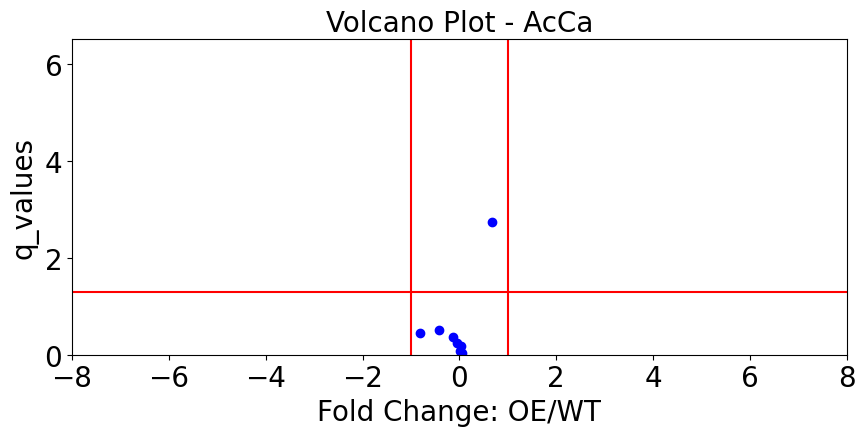

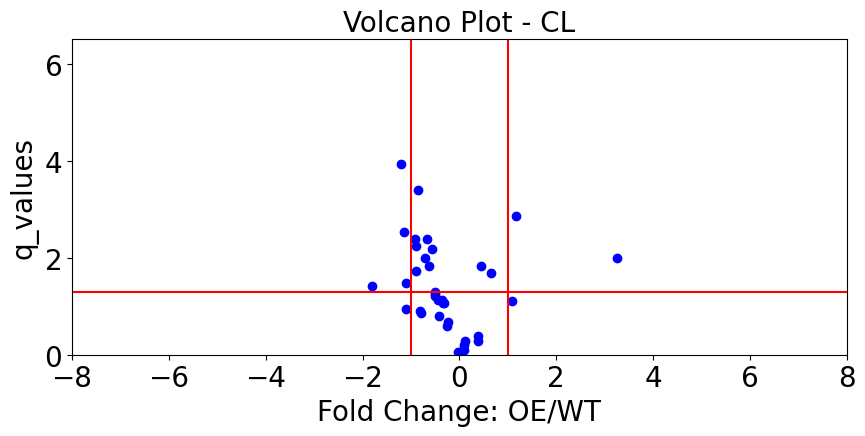

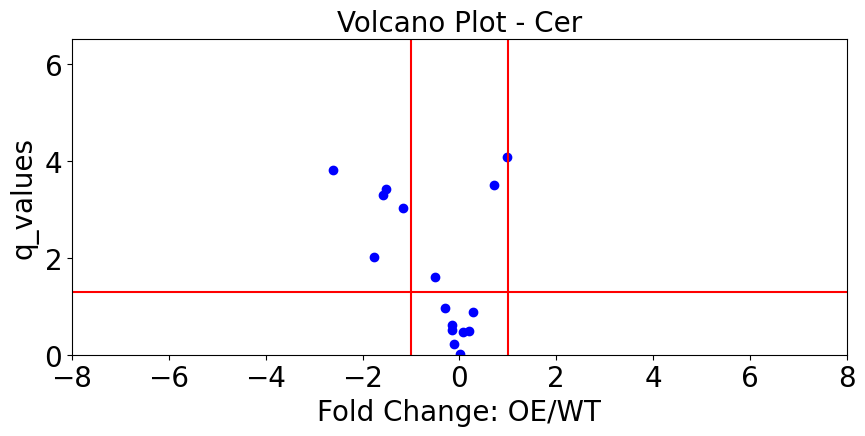

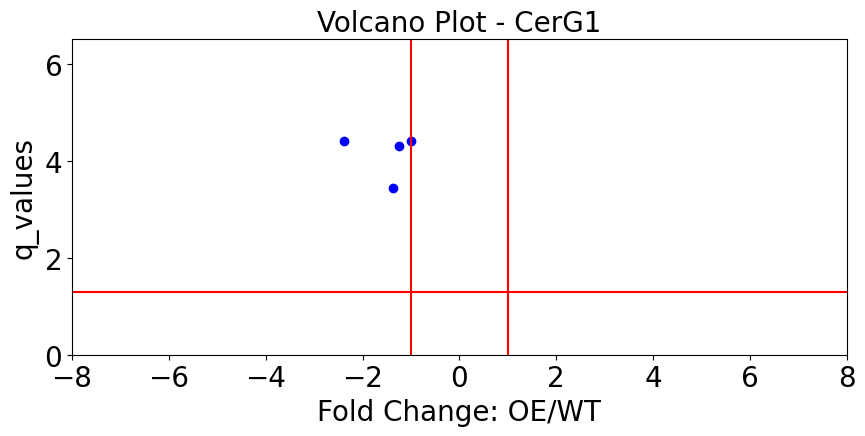

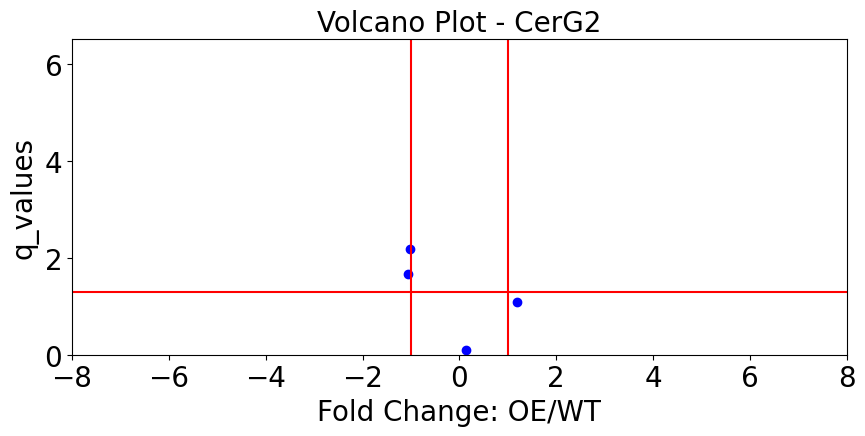

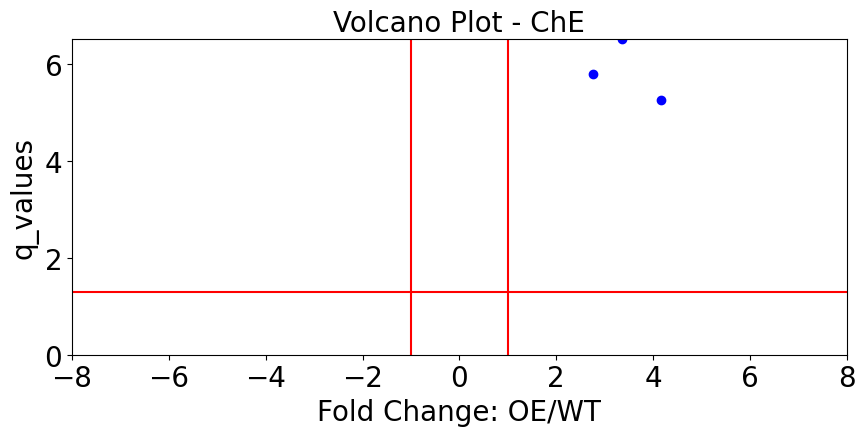

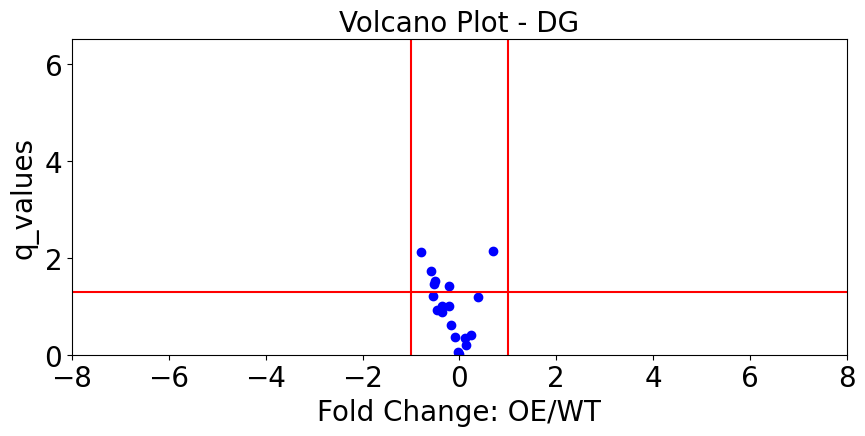

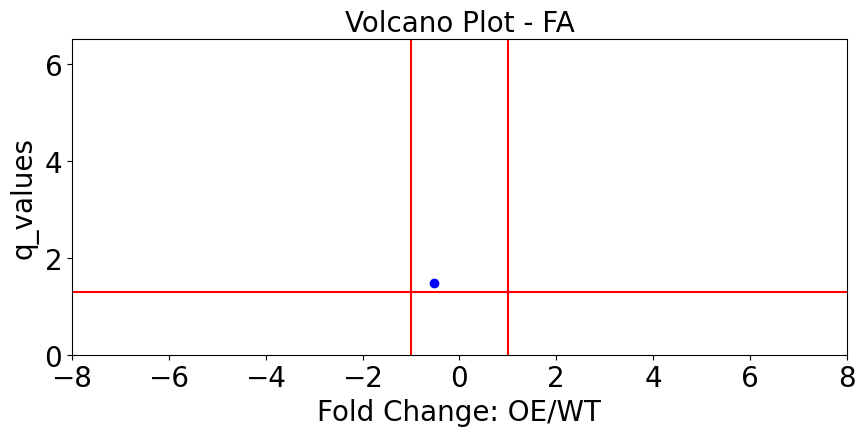

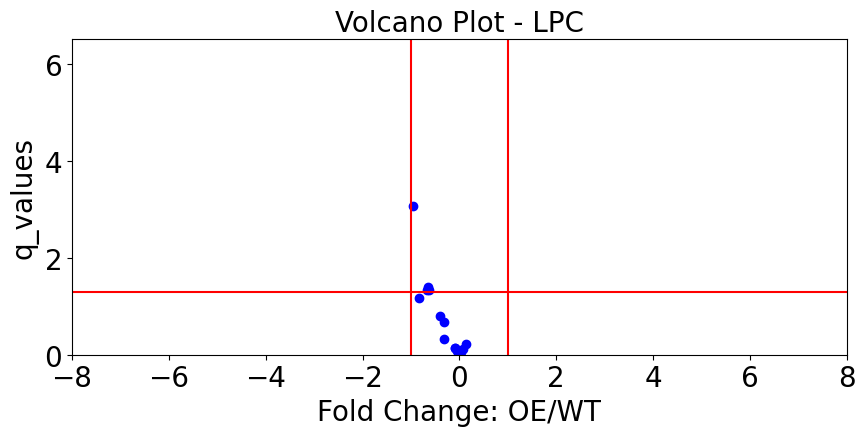

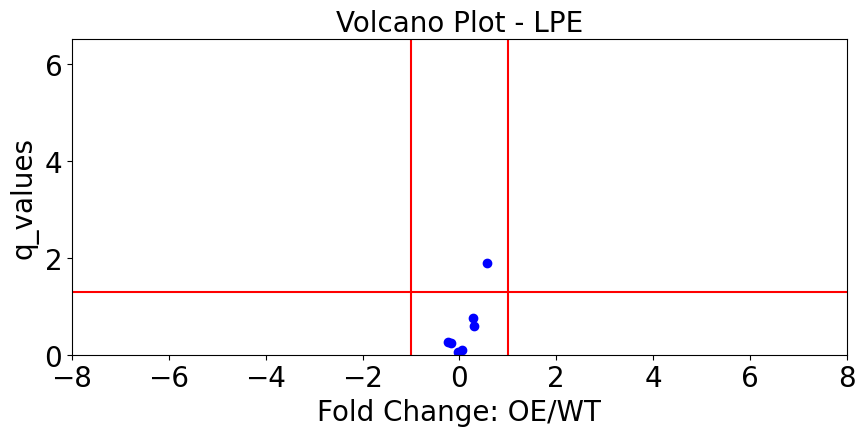

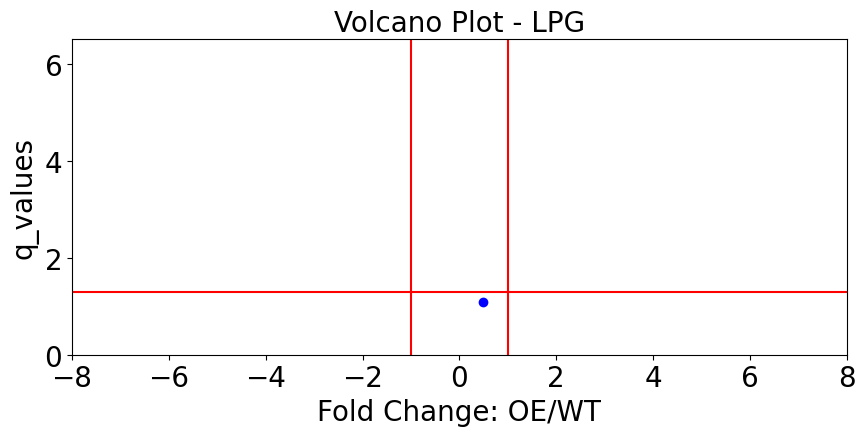

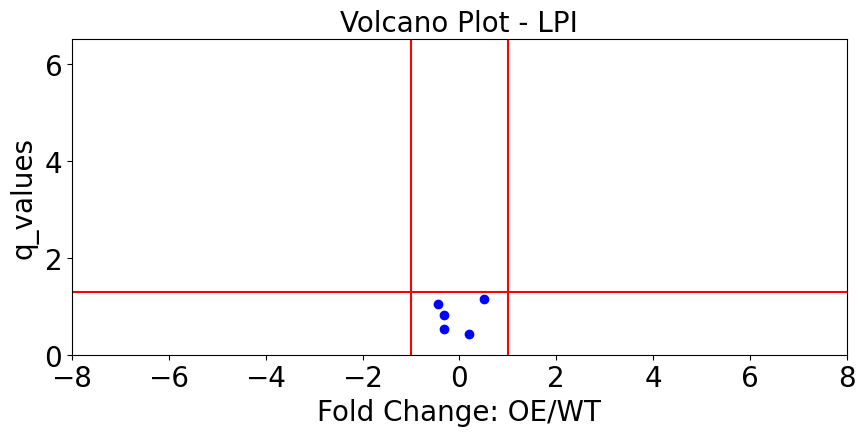

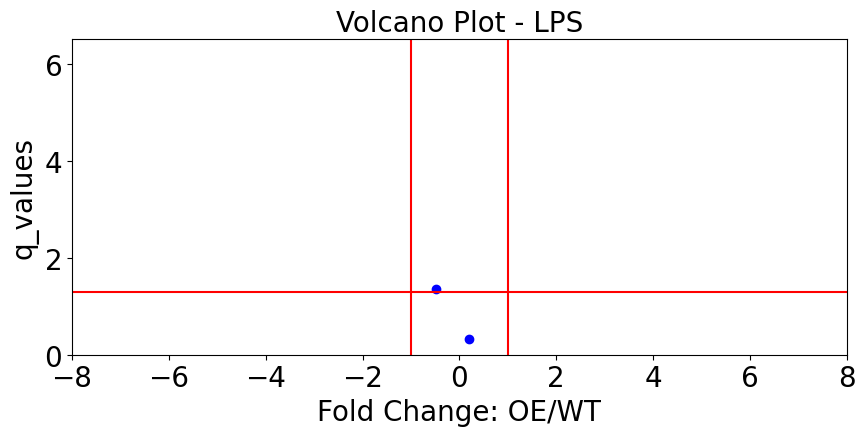

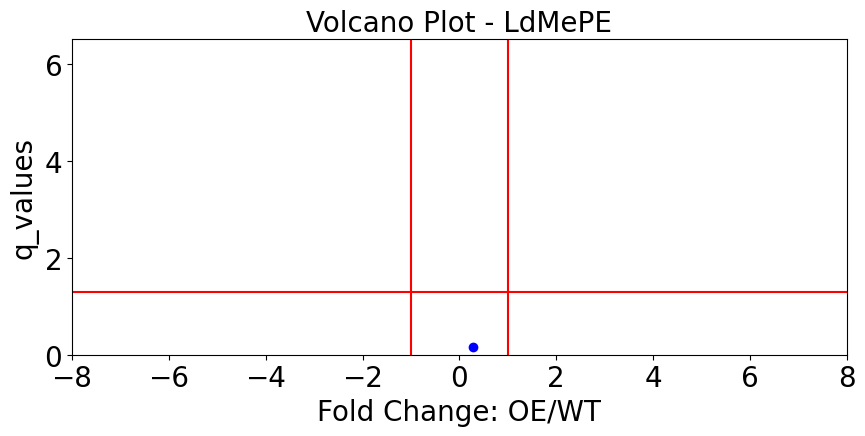

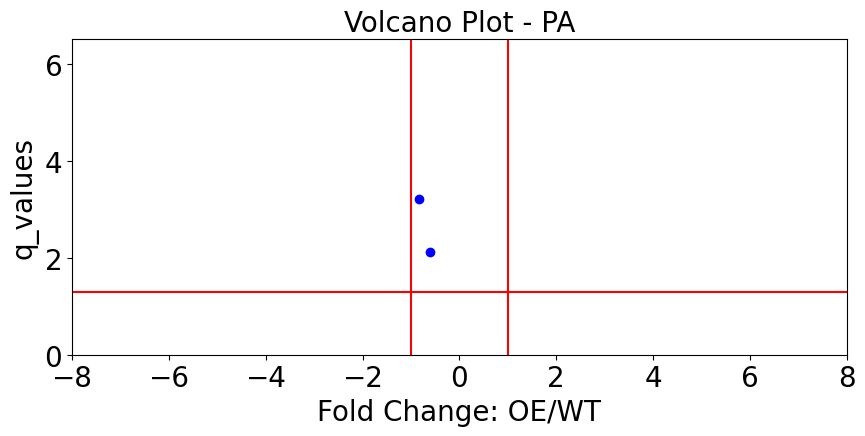

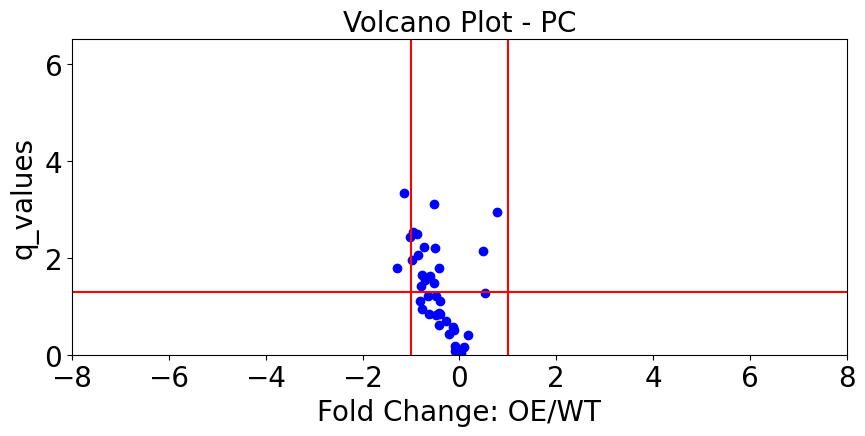

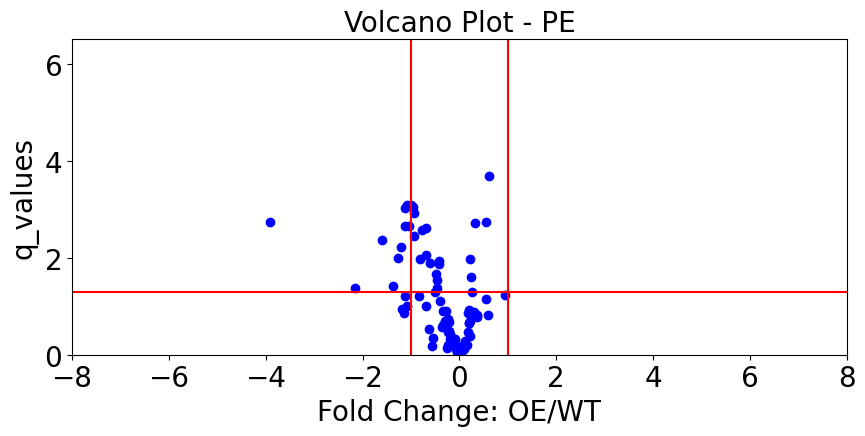

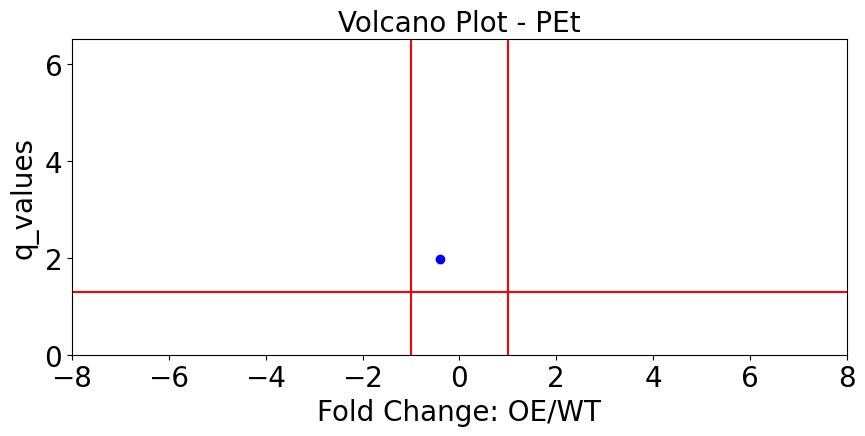

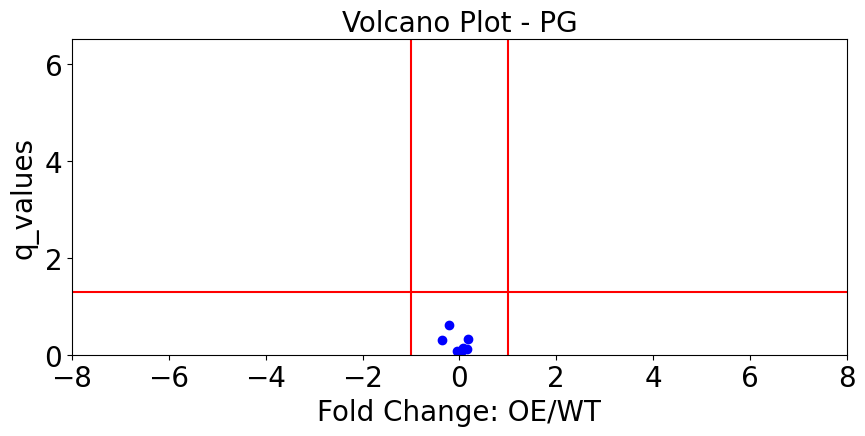

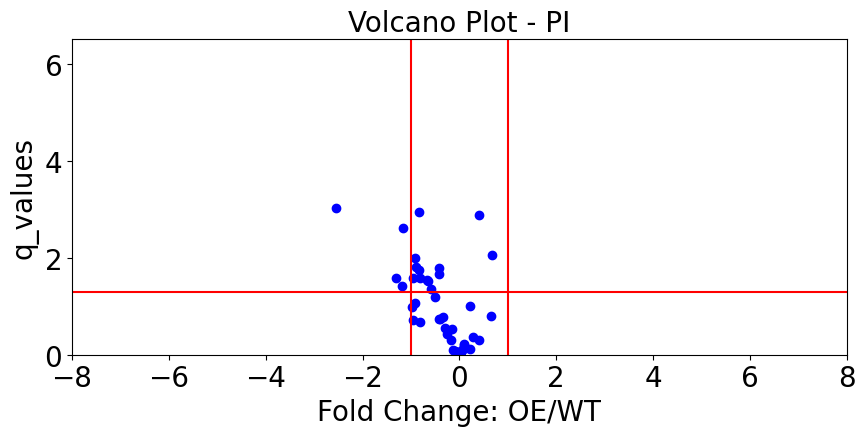

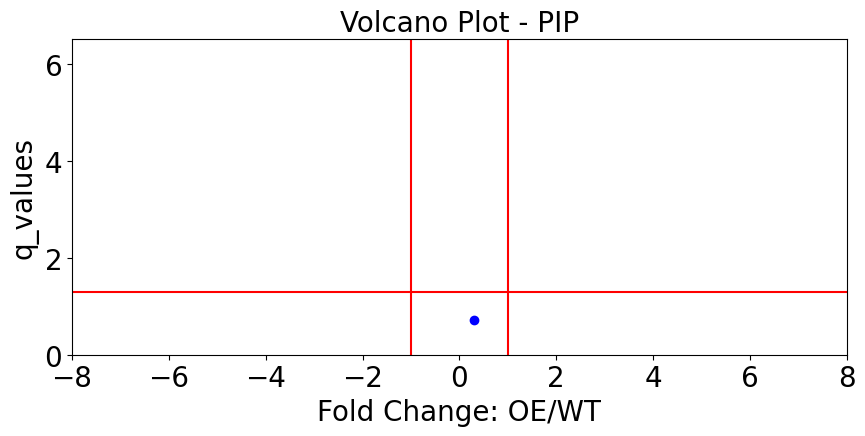

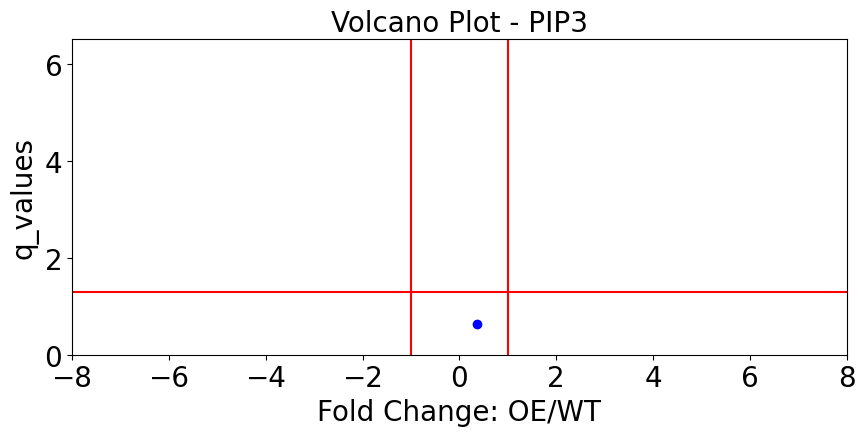

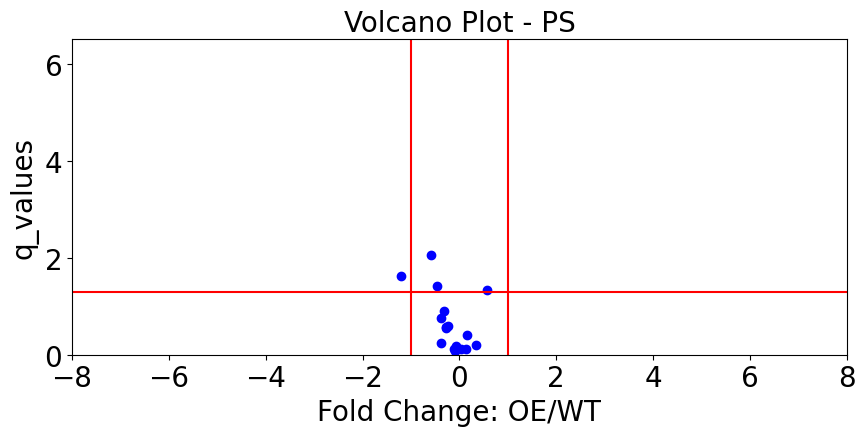

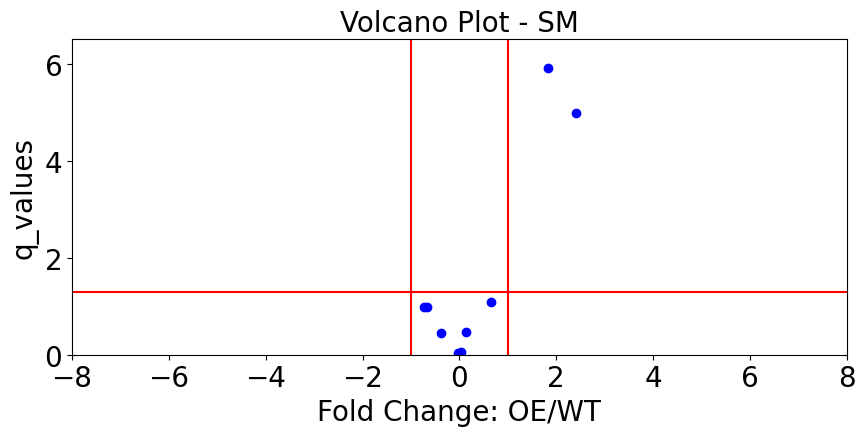

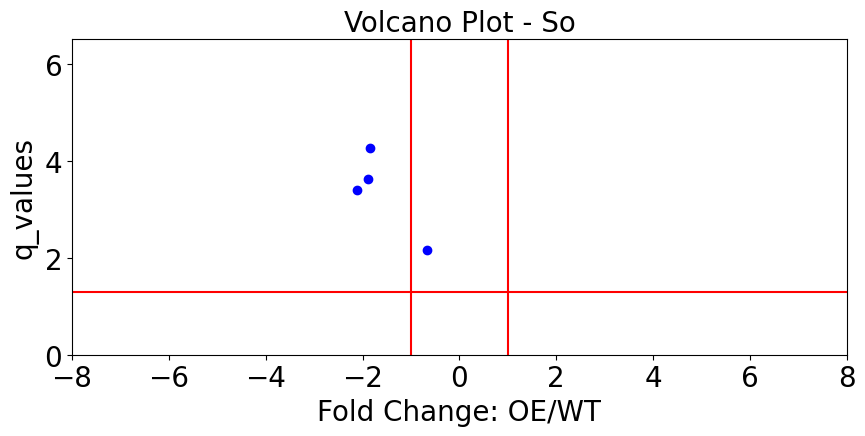

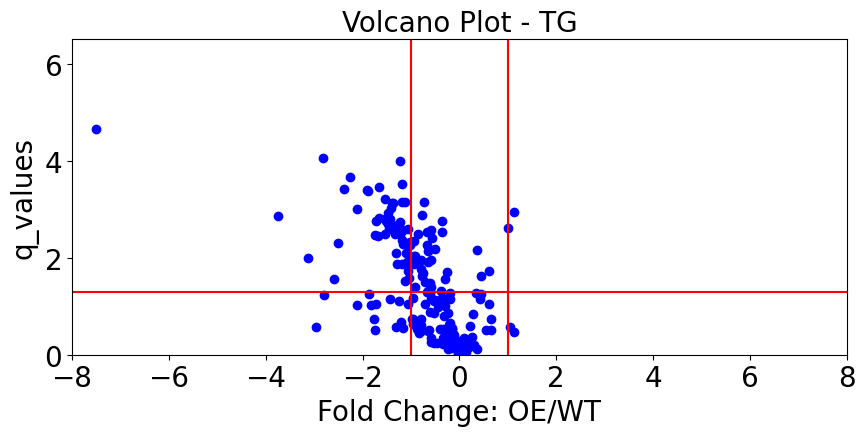

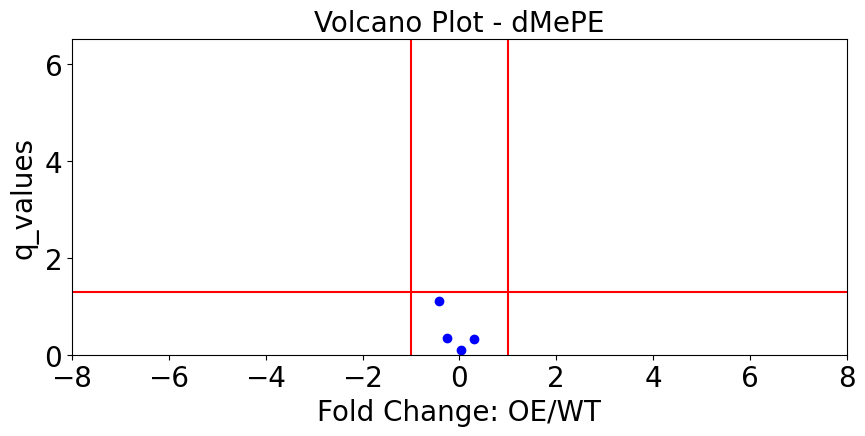

In [23]:
plot.create_volcano_plot(X)

**Note**: only the datapoints at the top right and top left quadrant are the ones with large and statistically significant fold change. For example, for the class AcCa, we observe no major difference between the conditions WT and OE. However, for the class ChE, we observe a large and statistically significant fold change for all the three lipid species when we compare the conditions WT and OE. 

### 5) Putting It All Together

Here is the whole code in one cell. Since this is supposed to be a re-usable script, let's try a different dataset: **test2**. Here are the inputs for test2 dataset:

**2 conditions: WT with 6 samples and KO with 6 samples.**

Enter the name of the dataset:
test2
Enter the number of conditions:
2
Create a label for condition number 1:
WT
Create a label for condition number 2:
KO
Enter the number of samples for condition number 1:
6
Enter the number of samples for condition number 2:
6
Enter the label of the control condition:
WT
Enter the label of the experimental condition:
KO
Enter the significance level:
0.05


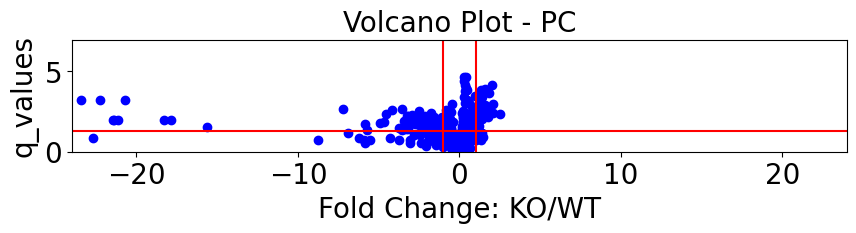

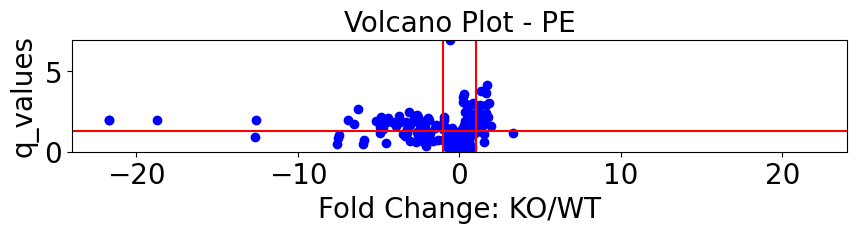

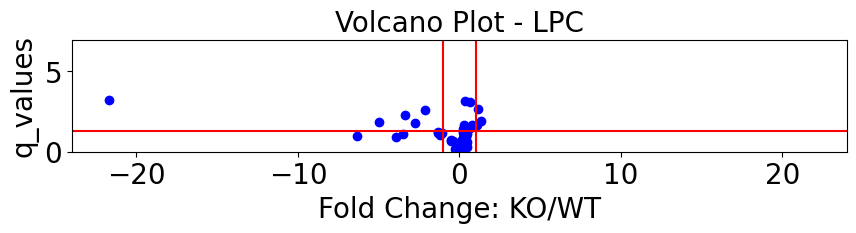

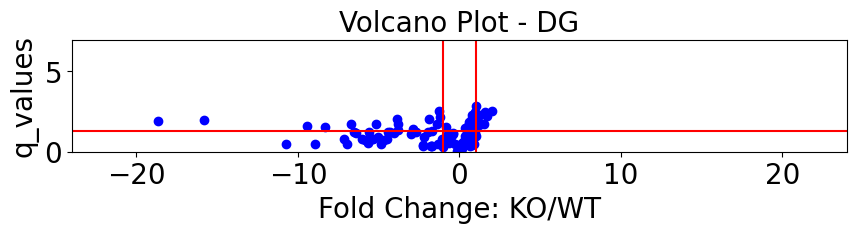

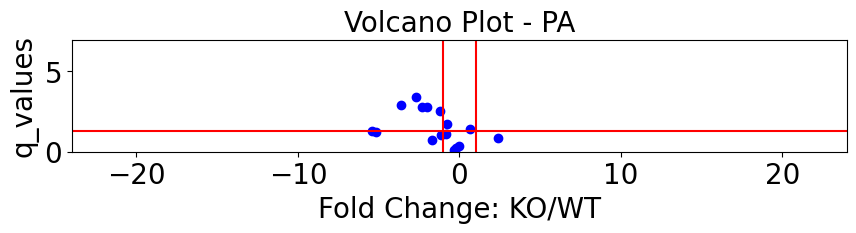

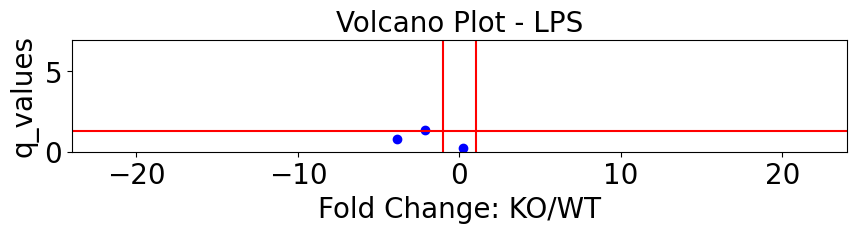

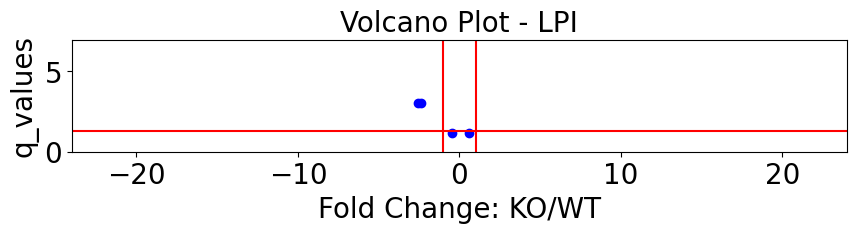

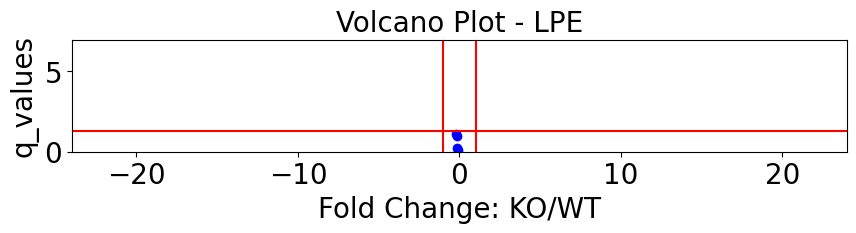

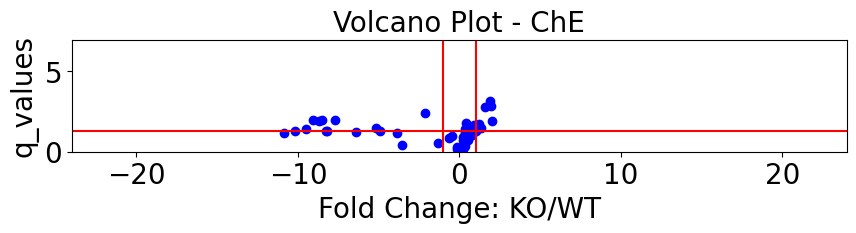

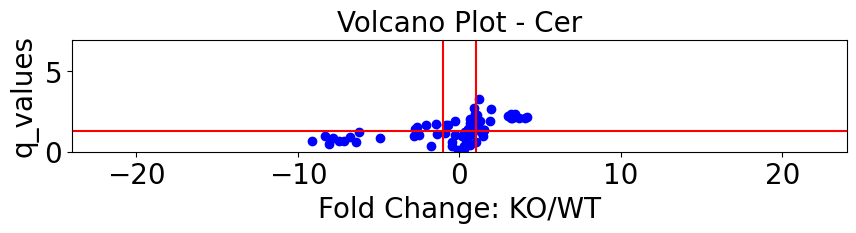

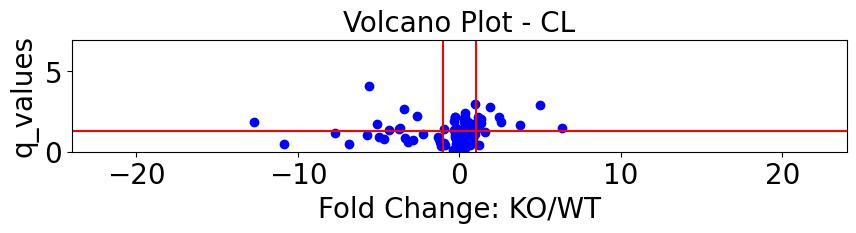

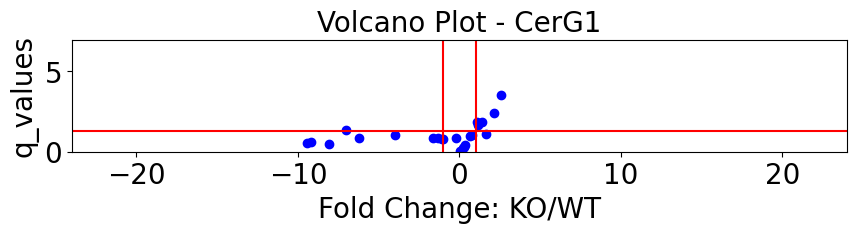

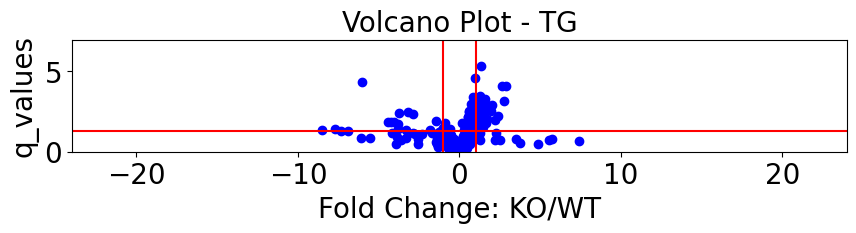

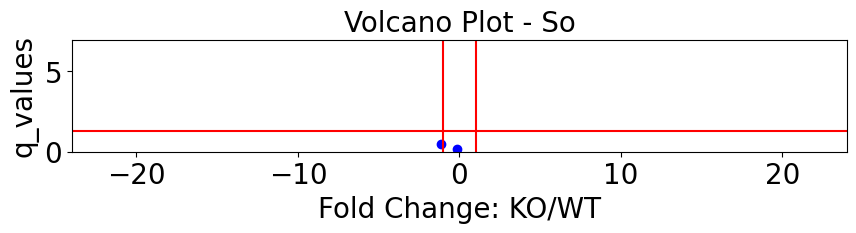

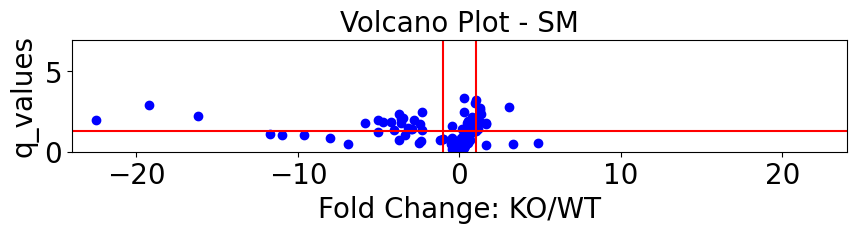

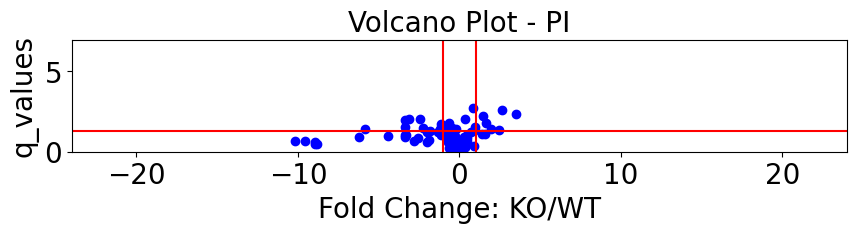

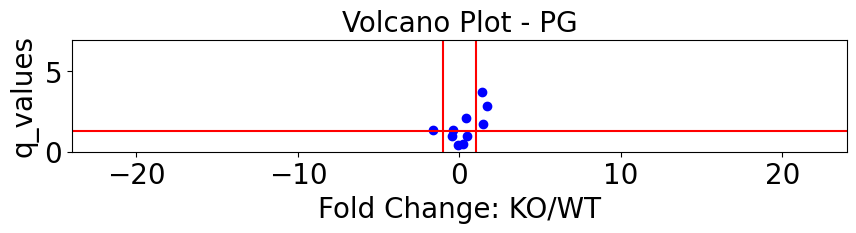

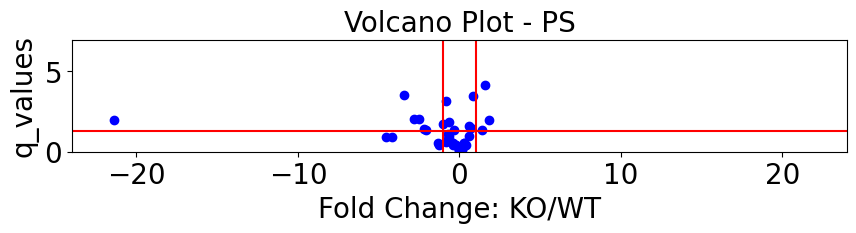

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

dataset_name = input('Enter the name of the dataset:\n')
df = pd.read_csv(dataset_name + '.csv')

###########################################################################################################################

class Experiment:
    
    def __init__(self):
        self.n_conditions = None
        self.conditions_list = []
        self.number_of_samples_list = []
        self.individual_samples_list = []
        self.full_samples_list = []
        
    def get_input(self):
        
        # Number of experimental groups or conditions
        def get_n_conditions():
            return int(input("Enter the number of conditions:\n"))
        
        self.n_conditions = get_n_conditions()

        # List of conditions
        def get_conditions_list():
            return [input("Create a label for condition number " + str(i+1) + ':\n')\
                    for i in range(self.n_conditions)]
        
        self.conditions_list = get_conditions_list()

        # List of the number of samples corresponding to each condition
        def get_number_of_samples_list():
            return [int(input("Enter the number of samples for condition number " + str(i+1) + ':\n'))\
                    for i in range(self.n_conditions)]
        
        self.number_of_samples_list = get_number_of_samples_list()
        
        # List of all samples 
        def create_full_samples_list():
            return ['s' + str(i+1) for i in range(sum(self.number_of_samples_list))]
        
        self.full_samples_list = create_full_samples_list()
        
        # List of the list of samples corresponding to each condition 
        def create_individual_samples_list():
            temporary_list = self.full_samples_list.copy() # Make a copy of full_sample_list to prevent affecting it 
            for condition, replicate in zip(self.conditions_list, self.number_of_samples_list):
                self.individual_samples_list.append(temporary_list[: replicate])
                del temporary_list[: replicate]
            return self.individual_samples_list
        
        self.individual_samples_list = create_individual_samples_list()
            
    def __repr__(self):
        return " conditions_list:{},\n number_of_samples_list:{},\n individual_samples_list:{},\n full_samples_list:{},\n"\
        .format(self.conditions_list, self.number_of_samples_list, self.individual_samples_list, self.full_samples_list)
    
    def __str__(self):
        return self.__repr__()
    
###########################################################################################################################
    
class CleanData:
    
    def __init__(self, dataframe, experiment_object):
        
        self.dataframe = dataframe
        
        self.experiment_object = experiment_object 
        
        # Check the validity of user inputs
        # Compare the total number of 'MainArea' columns in df with total number of replicates given by the user 
        if len([col for col in self.dataframe.columns if 'MainArea[s' in col]) != \
        len(self.experiment_object.full_samples_list):
            raise Exception ("The inputs are invalid")
        
    def clean_data(self):

        # Extract relevant columns for analysis 
        def extract_relevant_columns():
            return self.dataframe[['Rej','LipidMolec', 'Class', 'Calc Mass', 'BaseRt'] + 
                                  ['MainArea[' + sample + ']' for sample in self.experiment_object.full_samples_list]]
        
        clean_dataframe = extract_relevant_columns()
        
        # Apply filter
        def apply_filter():
            # removes the datapoint if 'Rej' = 1
            return clean_dataframe.loc[clean_dataframe['Rej'] == 0]
        
        clean_dataframe = apply_filter()
        
        # Impute missing values: replace 0 values by the smallest non-zero value in the column 
        def impute_missing_value(clean_dataframe):
            
            for sample in self.experiment_object.full_samples_list:

                non_zero_list = [ele for ele in clean_dataframe['MainArea[' + sample + ']'].values if ele > 0]

                impute_value = min(non_zero_list)

                clean_dataframe['MainArea[' + sample + ']'] = \
                clean_dataframe['MainArea[' + sample + ']'].apply(lambda x: impute_value if x<=0 else x)

            return clean_dataframe

        clean_dataframe = impute_missing_value(clean_dataframe)

        return clean_dataframe
    
###########################################################################################################################
    
class VolcanoPlot:
    
    def __init__(self):
        self.control = input("Enter the label of the control condition:\n")
        self.experimental = input("Enter the label of the experimental condition:\n")
        self.p_value_threshold = float(input("Enter the significance level:\n"))
        self.q_value_threshold = -np.log10(self.p_value_threshold)
        
    def add_fold_change_and_p_value_columns(self, clean_dataframe, experiment_object):
        
        def fold_change_calculator(nums_1, nums_2): 
            return np.log2(np.mean(nums_1)/np.mean(nums_2))
        
        def p_value_calculator(nums_1, nums_2):
            t_value, p_value = stats.ttest_ind(nums_1,nums_2)
            return p_value
        
        # get index of control and experimental conditions in experiment_object.conditions_list
        def get_index():
            return experiment_object.conditions_list.index(self.control),\
                   experiment_object.conditions_list.index(self.experimental)
            
        control_idx, experimental_idx = get_index()
        
        # get list of control samples and experimental samples from experiment_object.individual_samples_list
        def get_individual_samples_list():
            return experiment_object.individual_samples_list[control_idx], \
                   experiment_object.individual_samples_list[experimental_idx]
        
        control_samples_list, experimental_samples_list = get_individual_samples_list()
                        
        # add fold change column to clean_dataframe using "fold_change_calculator"
        clean_dataframe['fc_' + self.experimental + '_' + self.control] = \
        clean_dataframe[['MainArea[' + sample + ']'  for sample in control_samples_list + experimental_samples_list]]\
        .apply(lambda x: fold_change_calculator(x[['MainArea[' + sample + ']'  for sample in experimental_samples_list]], \
                                       x[['MainArea[' + sample + ']'  for sample in control_samples_list]]), axis=1)
        
        # add p_value column to clean_dataframe using "p_value_calculator"
        clean_dataframe['p_val_' + self.experimental + '_' + self.control] = \
        clean_dataframe[['MainArea[' + sample + ']'  for sample in control_samples_list + experimental_samples_list]]\
        .apply(lambda x: p_value_calculator(x[['MainArea[' + sample + ']'  for sample in experimental_samples_list]], \
                                          x[['MainArea[' + sample + ']'  for sample in control_samples_list]]), axis=1)
        
        return clean_dataframe
    
    def create_volcano_plot(self, clean_dataframe):
        
        def find_fold_change_axis_limit():
            max_fold_change = np.max(clean_dataframe['fc_' + self.experimental + '_' + self.control].values)
            min_fold_change = np.min(clean_dataframe['fc_' + self.experimental + '_' + self.control].values)
            return np.ceil(max(abs(max_fold_change), abs(min_fold_change)))
        
        fold_change_axis_limit = find_fold_change_axis_limit()
        
        def find_q_value_axis_limit():
            return -np.log10(np.min(clean_dataframe['p_val_' + self.experimental + '_' + self.control].values))
            
        q_value_axis_limit = find_q_value_axis_limit()
        
        # create a volcano plot for each lipid class 
        for lipid_class in clean_dataframe['Class'].unique():
            
            plt.rcParams.update({'figure.max_open_warning': 0})
            plt.rcParams["figure.figsize"] = [10, 10]
            
            fig, ax = plt.subplots()
            ax.set_title('Volcano Plot - ' + lipid_class, fontsize=20)
        
            ax.set_xlim([-fold_change_axis_limit, fold_change_axis_limit])
            ax.set_ylim([0, q_value_axis_limit])
            
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)
            
            plt.gca().set_aspect('equal', adjustable='box')
            
            ax.set_xlabel('Fold Change: ' + self.experimental + '/' + self.control, fontsize=20)              
            ax.set_ylabel('q_values', fontsize=20)
            
            # plot the horizontal solid red line 
            ax.plot([-fold_change_axis_limit, fold_change_axis_limit], \
                    [self.q_value_threshold, self.q_value_threshold], color='red')
        
            # plot the two vertical red lines 
            ax.plot([-1, -1], [0, q_value_axis_limit], color='red')
            ax.plot([1, 1], [0, q_value_axis_limit], color='red')
            
            # x and y values to be plotted 
            x = clean_dataframe['fc_' + self.experimental + '_' + self.control][clean_dataframe['Class'] == lipid_class]
            y = clean_dataframe['p_val_' + self.experimental + '_' + self.control][clean_dataframe['Class'] == lipid_class]
            
            ax.scatter(x, -np.log10(y), c='b')

###########################################################################################################################
experiment = Experiment() 
experiment.get_input()

clean_df = CleanData(df, experiment)
X = clean_df.clean_data()

plot = VolcanoPlot()
X = plot.add_fold_change_and_p_value_columns(X, experiment)
plot.create_volcano_plot(X)
        

It seems the code is working as intended. 

### 6) Building a Web App for Hypothesis Testing with Python 

With some modifications, I turned the above script into a streamlit app. For visualizations, I used Bokeh module. Bokeh plots are interactive and more clear. This is a toy version of LipidCruncher for demoing purposes. Here is the link to LipidCruncher Demo app: [LipidCruncher Demo App](https://haabdii-lipidcruncher-demo-volcano-plot-app-hua55p.streamlitapp.com/)

### 7) Summary

1) I have built LipidCruncher: an app for visualizing and statistical analysis of lipidomics data. [(Link to LipidCruncher Youtube Demo)](https://www.youtube.com/watch?v=KC4eLuwYw3A)

2) Since the source code of LipidCruncher is thousands of lines long, in this portfolio project, I demonstrated the code of a toy version of LipidCruncher with only one feature: volcano plots. I used Python classes to make the script re-usable.  

3) Volcano plots are useful for quickly visualizing and identifying lipid species that experience a large and statistically significant change in their abundaance when comaparing control and experimental groups.

5) With some modifications, I turned the script into a streamit app: [LipidCruncher Demo App](https://haabdii-lipidcruncher-demo-volcano-plot-app-hua55p.streamlitapp.com/)